# **시계열데이터 기반 회전체 고장예지진단 기법 개발  **
*Development of a Fault Prognosis and Diagnosis Method for Rotating Machinery Based on Time Series Data*

2024년도 밀리테크 연구, 2024-2팀

총 11개의 Class로 분류함.

파일명, 파일 내의 모드 개수 등에 따라 일부 코드의 수정이 필요합니다.
수정이 필요한 부분은 주석으로 표시했음. (총 5개 line에 대한 수정이 필요)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

def catch_into_dict(data_path):

    filenames = os.listdir(data_path)
    data = {}
    for f in filenames:
        filePath = os.path.join(data_path, f)
        file = io.loadmat(filePath)
        keys = file.keys()
        for key in keys:
            if 'mili' in key:                                                                                   #수정사항 1) 파일명에 따라서 수정해야하는 line임.
                data[f] = file[key].ravel()
                """
                print(data[f].shape)
                plt.figure()
                X = np.arange(0, 1024)
                plt.plot(X, np.array(file[key].ravel())[0:1024])
                plt.show()
                """
    return data

def slice_data(data, length=864, number=1000, slice_rate=[0.7, 0.2, 0.1], enc=True, enc_step=28):
    """
        train_samples
        test_and_valid_samples
        length
        number，기본값 1000
        slicer_rate
        enc
        enc_step """
    train_samples = {}
    test_and_valid_samples = {}
    keys = data.keys()

    for key in keys:
        train_data = []
        total_length = len(data[key])
        end_index = int(total_length * slice_rate[0])
        train_num = int(number * slice_rate[0])
        if enc:
            enc_times = length // enc_step
            steps = 0
            for j in range(train_num):
                label = False
                start_index = np.random.randint(low=0, high=end_index - 2 * length)
                for h in range(enc_times):
                    temp = data[key][start_index:start_index + length]
                    train_data.append(temp)
                    steps += 1
                    start_index = start_index + enc_step
                    if steps == train_num:
                        label = True
                        break
                if label:
                    break
        else:
            for j in range(train_num):
                start_index = np.random.randint(low=0, high=end_index - 2 * length)
                temp = data[key][start_index: start_index + length]
                train_data.append(temp)
        train_samples[key] = np.array(train_data)
        test_and_valid_num = int(number * (1 - slice_rate[0]))
        test_and_valid_data = []
        for j in range(test_and_valid_num):
            start_index = np.random.randint(low=end_index, high=total_length - length)
            temp = data[key][start_index: start_index + length]
            test_and_valid_data.append(temp)
        test_and_valid_samples[key] = np.array(test_and_valid_data)

    return train_samples, test_and_valid_samples

def add_label(data):
    """B007~B021，IR007~IR021, OR007~OR021, normal 0~9
        onehot
        data """
    label = 0
    X = []
    Y = []
    for key in data.keys():
        x_len = len(data[key])
        y = [label] * x_len
        Y.append(y)
        X.append(data[key])
        label += 1

    X = np.array(X)
    X = X.reshape((-1, X.shape[-1]))
    return X, np.array(Y).ravel()

def one_hot(data_Y):
    """one_hot
        """
    Encoder = preprocessing.OneHotEncoder()
    data_Y = data_Y.reshape((-1, 1))
    Encoder.fit(data_Y)
    Y = Encoder.transform(data_Y).toarray()
    Y = np.asarray(Y, dtype=np.int32)
    return Y

def slice_test_and_valid(te_va_X, te_va_Y, slice_rate=[0.7, 0.2, 0.1]):
    """
        te_va_X
        te_va_Y
        slice_rate
        text_X
        test_Y
        valid_X
        valid_Y """
    ss = StratifiedShuffleSplit(n_splits=1,
                                train_size=slice_rate[1] / (slice_rate[1] + slice_rate[2]))

    for test_index, valid_index in ss.split(te_va_X, te_va_Y):
        test_X, valid_X = te_va_X[test_index], te_va_X[valid_index]
        test_Y, valid_Y = te_va_Y[test_index], te_va_Y[valid_index]
    return test_X, test_Y, valid_X, valid_Y

def prepro(data_path, length=864, number=1000, slice_rate=[0.7, 0.2, 0.1], enc=True, enc_step=28, normal=False):
    """
    :param data_path
    :param length
    :param number
    :param slice_rate
    :param enc
    :param enc_step
    :param normal
    :return: train_X, test_X, valid_X, one_hot train_Y, test_Y, valid_Y
    """
    data = catch_into_dict(data_path)
    train_data, test_and_valid_data = slice_data(data, length=length, number=number, slice_rate=slice_rate,
                                                 enc=enc, enc_step=enc_step)
    train_X, train_Y = add_label(train_data)
    test_and_valid_X, test_and_valid_Y = add_label(test_and_valid_data)
    train_Y = one_hot(train_Y)
    test_and_valid_Y = one_hot(test_and_valid_Y)

    if normal:
        scaler1 = StandardScaler()
        train_X = scaler1.fit_transform(train_X)
        scaler2 = StandardScaler()
        test_and_valid_X = scaler2.fit_transform(test_and_valid_X)
    test_X, text_Y, valid_X, valid_Y = slice_test_and_valid(test_and_valid_X, test_and_valid_Y, slice_rate=slice_rate)
    return train_X, train_Y, test_X, text_Y, valid_X, valid_Y

if __name__ == "__main__":
    normal = True

    data_path = "/content/drive/MyDrive/only_5modes"                                                                    #2) 파일 경로에 따라 수정해야하는 line임.
    train_X, train_Y, test_X, test_Y, valid_X, valid_Y = prepro(data_path=data_path, length=864, number=1000,
                                                                slice_rate=[0.7, 0.2, 0.1],
                                                                enc=True,
                                                                enc_step=28,
                                                                normal=False)

In [ ]:
!pip install preprocess

In [ ]:
import torch
import numpy as np
from torch import nn
import torch.utils.data as Data
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

def slice_to_batch_size(data_X, data_Y, batch_size, shuffle=True):
    """
    배치 크기로 데이터를 나누는 함수
    :param data_X: 입력 데이터
    :param data_Y: 출력 데이터
    :param batch_size: 배치 크기
    :param shuffle: 데이터 셔플 여부
    :return: 배치 단위로 데이터 반환
    """
    torch_dataset = Data.TensorDataset(data_X, data_Y)
    data_iter = Data.DataLoader(dataset=torch_dataset, batch_size=batch_size, shuffle=True)
    return data_iter

def try_gpu(i=0):
    """사용 가능한 GPU를 반환합니다."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    """정확도를 계산하는 함수"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y_true = y.clone()
    y_true = y_true.argmax(axis=1)
    cmp = y_hat.type(y_true.dtype) == y_true
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """GPU에서 모델 정확도를 평가합니다."""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), len(y))
    return metric[0] / metric[1]

class Accumulator:
    """누적합을 계산하는 도우미 클래스"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """축을 설정하는 함수"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """실시간 학습 곡선 애니메이션을 위한 클래스"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):

        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]

        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim,
                                            xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        plt.draw()

    def show(self):
        plt.show()

def train(net, train_iter, test_iter, num_epochs, lr, device):
    """
    모델을 학습시키는 함수
    :param net: 모델
    :param train_iter: 학습 데이터 반복자
    :param test_iter: 테스트 데이터 반복자
    :param num_epochs: 학습 에포크 수
    :param lr: 학습률
    :param device: 사용할 디바이스
    """
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print("training on ", device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f},'
          f'test acc {test_acc:.3f}')
    animator.show()


In [ ]:
import torch
import preprocess
import numpy as np
from torch import nn
import torch.utils.data as Data
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display

def slice_to_batch_size(data_X, data_Y, batch_size, shuffle=True):
    """
    batcha_size
    :param data_X
    :param data_Y
    :batcha_size: batch_size
    :param shuffle
    :return: data_iter
    """
    torch_dataset = Data.TensorDataset(data_X, data_Y)
    data_iter = Data.DataLoader(dataset=torch_dataset, batch_size=batch_size, shuffle=True)
    return data_iter

def try_gpu(i=0):
    """hihi"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    """batch"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y_true = y.clone()
    y_true = y_true.argmax(axis=1)
    cmp = y_hat.type(y_true.dtype) == y_true
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """gpu"""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), len(y))
    return metric[0] / metric[1]

class Accumulator:

    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        """
        :param args
        :return
        """
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):

        if legend is None:
            legend=[]
        backend_inline.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]

        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim,
                                            xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):

        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        plt.draw()
        plt.pause(0.001)
        display.display(self.fig)
        display.clear_output(wait=True)

    def show(self):
        display.display(self.fig)

def train(net, train_iter, test_iter, num_epochs, lr, device):
    """
    :param net
    :param train_iter
    :param test_iter
    :param num_epochs
    :param lr
    :param device
    :return
    """
    def init_weights(m):

        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print("training on ", device)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()

            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f},'
              f'test acc {test_acc:.3f}')
    plt.show()

In [ ]:
!pip install train

  Preparing metadata (setup.py) ... done
  Created wheel for train: filename=train-0.0.5-py3-none-any.whl size=8491 sha256=8ba21dc666dce9d7a68653ab806a5776e153008a9e8683f26f93f5824563da8b
  Stored in directory: /root/.cache/pip/wheels/70/b9/f3/c3ff20f48c8602e236ed0f8d51817962f176c304ef0a3011ec
Successfully built train


training on  cuda:0
loss 0.000, train acc 1.000,test acc 1.000


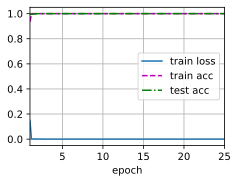

In [ ]:
import torch
import preprocess
from torch import nn
import train as tr

batch_size = 128
epochs = 25
num_classer = 4                                                                #3) classer의 개수에 따라 수정해야 함. 본 연구에서는 총 5개의 고장모드, 11개의 classer.

length = 2048
BatchNorm = True
number = 1000
normal = True
rate = [0.7, 0.2, 0.1]

path = "/content/drive/MyDrive/only_5modes"                                     #4) 파일 경로를 수정해야 함.
train_X, train_Y, test_X, test_Y, valid_X, valid_Y = prepro(data_path=path,
                                                                       length=length,
                                                                       number=number,
                                                                       slice_rate=rate,
                                                                       enc=True,
                                                                       enc_step=28,
                                                                       normal=normal)

train_X = torch.from_numpy(train_X).float()
train_Y = torch.from_numpy(train_Y).float()
test_X = torch.from_numpy(test_X).float()
test_Y = torch.from_numpy(test_Y).float()
valid_X = torch.from_numpy(valid_X).float()
valid_Y = torch.from_numpy(valid_Y).float()

train_X = train_X[:, None, :]
test_X = test_X[:, None, :]
valid_X = valid_X[:, None, :]

train_iter = slice_to_batch_size(train_X, train_Y, batch_size=batch_size, shuffle=True)
test_iter = slice_to_batch_size(test_X, test_Y, batch_size=batch_size, shuffle=True)

'''
train_X = train_X.reshape(2800, 2048)
test_X = test_X.reshape(800, 2048)
valid_X = valid_X.reshape(400, 2048)
'''

#Architecture
net = nn.Sequential(
       #1st Convolution layer & Pulling, Output: (None, 16, 64)
        nn.Conv1d(1, 16, kernel_size=64, stride=16, padding=24), nn.BatchNorm1d(16), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        #2nd Convolution layer & Pulling, Output (None, 32, 32)
        nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1), nn.BatchNorm1d(32), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        #3rd Convolution layer & Pulling, Output (None, 64, 16)
        nn.Conv1d(32, 64, kernel_size=3, padding=1), nn.BatchNorm1d(64), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        #4th Convolution layer & Pulling, Output (None, 64, 8)
        nn.Conv1d(64, 64, kernel_size=3, padding=1), nn.BatchNorm1d(64), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        #5th Convolution layer & Pulling, Output (None, 64, 3)
        nn.Conv1d(64, 64, kernel_size=3), nn.BatchNorm1d(64), nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2),
        #Pulling result -> flatten，Shape:（None, 192）
        nn.Flatten(),
        nn.Linear(192, 100), nn.ReLU(),

        nn.Linear(100, 4)                                                                #5) classer의 개수에 따라 바꿔줘야 함
        # nn.Softmax(dim=1) #softmax layer is added automatically
)

# Test
"""
X = torch.randn(1, 1, 2048)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
"""

train(net, train_iter, test_iter, num_epochs=epochs, lr=0.01, device=try_gpu())